In [1]:
import os
import string
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#import tensorflow as tf

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# K-means and GMM

In [3]:
def calculate_euclidean_dist(x,y):
    return np.sqrt(np.sum((x-y)**2))
    
def k_means_clustering(data, K = 3):

    n = data.shape[0]
    label = np.hstack([np.ones(100)*0, np.ones(100)*1, np.ones(100)*2])
    
    # Assign random centers
    centers = data[np.random.choice(n, K, replace=False)]
    centers0 = centers
    
    cluster_assign = np.zeros(n) # random assign
    stopping_criteria = 5 # random number
    
    while stopping_criteria > 0:
        
        # Assign/Update clusters
        dist = np.zeros((n, K))
        for i in range(n):
            for j in range(K):
                dist[i, j] = calculate_euclidean_dist(data[i,:], centers[j,:])
        cluster_assign = np.argmin(dist, axis = 1)
    
        # Update centers
        centers = np.array([np.mean(data[cluster_assign == j,:], axis = 0) for j in range(K)])
        stopping_criteria = calculate_euclidean_dist(centers0, centers)
        centers0 = centers
    
    # Calculate clustering objective
    loss = 0
    for j in range(K):
        cluster_subset = data[cluster_assign==j]
        loss += np.sum([calculate_euclidean_dist(cluster_subset[i], centers[j,:]) for i in range(cluster_subset.shape[0])])

    # Calculate accuracy
    accuracy = np.mean(cluster_assign==label)
        
    return cluster_assign, centers, loss, accuracy

def GMM(data, K):

    n, p = data.shape
    label = np.hstack([np.ones(100)*0, np.ones(100)*1, np.ones(100)*2])
    
    # Random initialization
    pi = np.random.rand(K)
    pi /= np.sum(pi) # sum(pi) = 1
    mu = data[np.random.choice(n, K, replace=False)]
    Sigma = [np.eye(p) for _ in range(K)]
    
    # EM-algorithm
    iter = 0
    while (iter <= 500):
        w = Estep(data, pi, mu, Sigma, K)
        pi, mu, Sigma = Mstep(data, w, mu, Sigma)
        iter += 1
    
    # Assign clusters
    dist = np.zeros((n, K))
    for i in range(n):
        for j in range(K):
            dist[i, j] = calculate_euclidean_dist(data[i,:], mu[j])
    cluster_assign = np.argmin(dist, axis = 1)
    
    # Calculate clustering objective
    loss = 0
    for j in range(K):
        cluster_subset = data[cluster_assign==j]
        loss += np.sum([calculate_euclidean_dist(cluster_subset[i], mu[j]) for i in range(cluster_subset.shape[0])])
    
    # Calculate accuracy
    accuracy = np.mean(cluster_assign==label)

    return cluster_assign, mu, loss, accuracy

def calculate_gaussian_pdf(data, mu, Sigma, j):

    n, p = data.shape
    
    diff = data - mu[j]
    inv_Sigma = np.linalg.pinv(Sigma[j])
    c1 = (2 * np.pi)**(-p/2) 
    c2 = (np.linalg.det(Sigma[j])) ** (-1/2)
    c3 = np.exp(-0.5 * np.sum(diff.dot(inv_Sigma) * diff, axis=1))
    
    return c1 * c2 * c3

def Estep(data, pi, mu, Sigma, K):

    # Estiamte latent variable
    n, p = data.shape
    
    w = np.zeros((n, K))
    for j in range(K):
        w[:,j] = pi[j] * calculate_gaussian_pdf(data, mu, Sigma, j)
    w /= w.sum(axis=1, keepdims=True) # normalization

    return w

def Mstep(data, w, mu, Sigma):

    n = data.shape[0]
    w_sum = w.sum(axis = 0)
    pi = w_sum/n
    
    for j in range(K):
        mu[j] = np.sum(data * w[:,j].reshape(-1, 1), axis = 0) / w_sum[j]
        diff = data - mu[j]
        Sigma[j] = np.dot(diff.T, diff * w[:,j].reshape(-1,1)) / w_sum[j]

    return pi, mu, Sigma

def generate_data(sigma):
    
    means = np.array([[-1, -1], [1, -1], [0, 1]])
    cov = sigma * np.array([[[2, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 2]], [[1, 0], [0, 2]]])
    
    data = np.zeros((0, 2))
    for i in range(3):
        sample = np.random.multivariate_normal(means[i], cov[i], 100)
        data = np.vstack((data, sample))
        
    return data
    
def save_best_results(data, K, method):

    # save results with the lowest clustering objective
    best_result = None
    lowest_loss = float('inf')
    iter = 0
    
    while (iter < 100):
        if (method == "Kmeans"):
            result = k_means_clustering(data, K)
        if (method == "GMM"):
            try: # if converge issue, pass
                result = GMM(data, K)
            except:
                pass
                
        loss = result[2]
        if loss < lowest_loss:
            best_result = result
            lowest_loss = loss
    
        iter += 1

    return result

In [4]:
K = 3
sigma_list = [0.5, 1, 2, 4, 8]
loss_list_kmeans, accuracy_list_kmeans = [], []
loss_list_gmm, accuracy_list_gmm = [], []

for sigma in sigma_list:
    data = generate_data(sigma)
    results = save_best_results(data, K, "Kmeans")
    loss_list_kmeans.append(results[2])
    accuracy_list_kmeans.append(results[3])
    results = save_best_results(data, K, "GMM")
    loss_list_gmm.append(results[2])
    accuracy_list_gmm.append(results[3])

/var/folders/98/gq7_t55j62v7jbmngfldbqs80000gn/T/ipykernel_57884/1043587865.py:84: RuntimeWarning: divide by zero encountered in scalar power
  c2 = (np.linalg.det(Sigma[j])) ** (-1/2)
/var/folders/98/gq7_t55j62v7jbmngfldbqs80000gn/T/ipykernel_57884/1043587865.py:97: RuntimeWarning: invalid value encountered in divide
  w /= w.sum(axis=1, keepdims=True) # normalization
/var/folders/98/gq7_t55j62v7jbmngfldbqs80000gn/T/ipykernel_57884/1043587865.py:108: RuntimeWarning: invalid value encountered in divide
  mu[j] = np.sum(data * w[:,j].reshape(-1, 1), axis = 0) / w_sum[j]


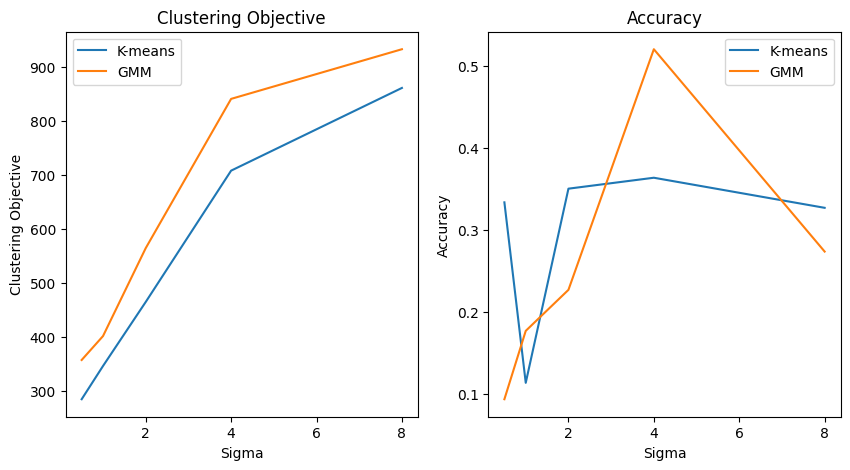

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(sigma_list, loss_list_kmeans)
ax1.plot(sigma_list, loss_list_gmm)
ax1.set(xlabel = 'Sigma', ylabel = 'Clustering Objective')
ax1.set_title('Clustering Objective')
ax1.legend(['K-means', 'GMM'])

ax2.plot(sigma_list, accuracy_list_kmeans)
ax2.plot(sigma_list, accuracy_list_gmm)
ax2.set(xlabel = 'Sigma', ylabel = 'Accuracy')
ax2.set_title('Accuracy')
ax2.legend(['K-means', 'GMM'])

plt.show()

# PCA

In [6]:
def buggy_PCA(X, d = 1):

    cov_matrix = X.T @ X
    
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    
    V = eigenvectors[:, sorted_idx[:d]]
    z = X @ V # low dimensional representation
    rec_X = z @ V.T

    return z, V, rec_X

def demeaned_PCA(X, d = 1):
    
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
        
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    
    V = eigenvectors[:, sorted_idx[:d]]
    z = X_centered @ V # low dimensional representation
    rec_X = z @ V.T + np.mean(X, axis=0)
    
    return z, V, rec_X

def normalized_PCA(X, d = 1):
    
    X_centered = X - np.mean(X, axis = 0)
    X_scaled = X_centered / np.std(X_centered, axis = 0)
    cov_matrix = np.cov(X_scaled, rowvar=False)
    
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
        
    V = eigenvectors[:, sorted_idx[:d]]
    z = X_scaled @ V # low dimensional representation
    rec_X = (z @ V.T) * np.std(X_centered, axis = 0) + np.mean(X, axis=0)

    return z, V, rec_X

def DRO(X, d = 1):
    n = X.shape[0]
    iter = 0
    
    z, V, rec_X = demeaned_PCA(X, d = 1) # for initial A, Z
    
    while (iter < 10):
        # Estimate b
        b = (X.T @ np.ones(n) - V @ z.T @ np.ones(n)) / n
    
        # truncated SVD
        Y = X - np.ones(n).reshape(-1,1) @ b.reshape(1,-1)
        U, S, VT = np.linalg.svd(Y)
        z = U[:,d].reshape(-1,1)
        V = (S[:d] * np.eye(d) * VT[:d,:]).T
    
        iter += 1

    rec_X = z @ V.T + b
    
    return z, V, rec_X

In [7]:
X = np.loadtxt("data/data2D.csv", delimiter = ",")

In [8]:
z_buggy, V_buggy, rec_X_buggy = buggy_PCA(X, d = 1)
rec_error_buggy = np.sum([calculate_euclidean_dist(X[i], rec_X_buggy[i])**2 for i in range(X.shape[0])])

z_demeaned, V_demeaned, rec_X_demeaned = demeaned_PCA(X, d = 1)
rec_error_demeaned = np.sum([calculate_euclidean_dist(X[i], rec_X_demeaned[i])**2 for i in range(X.shape[0])])

z_norm, V_norm, rec_X_norm = normalized_PCA(X, d = 1)
rec_error_norm = np.sum([calculate_euclidean_dist(X[i], rec_X_norm[i])**2 for i in range(X.shape[0])])

z_dro, V_dro, rec_X_dro = DRO(X, d = 1)
rec_error_dro = np.sum([calculate_euclidean_dist(X[i], rec_X_dro[i])**2 for i in range(X.shape[0])])

In [9]:
print(rec_error_buggy, rec_error_demeaned, rec_error_norm, rec_error_dro)

44.34515418673971 0.500304281425646 2.4736041727385336 131.85713508637735


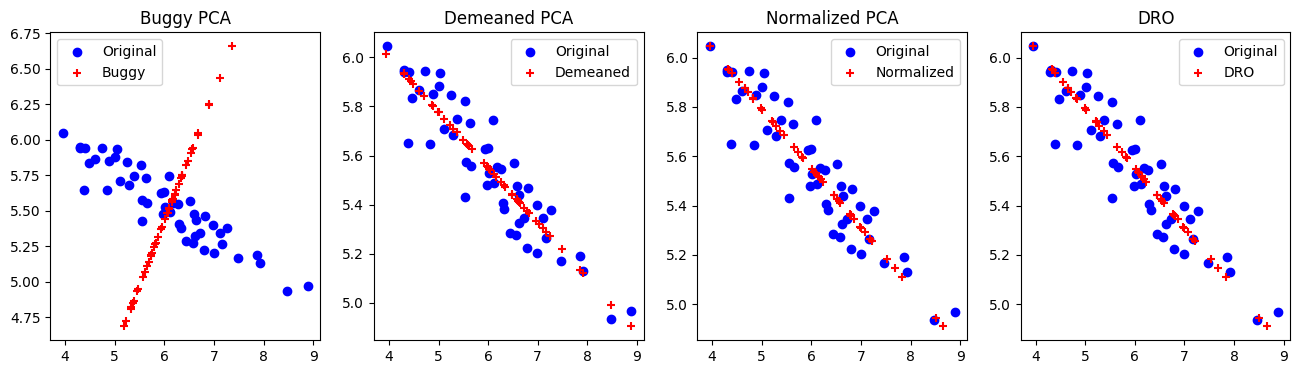

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))

ax1.scatter(X[:,0], X[:,1], c = "blue")
ax1.scatter(rec_X_buggy[:,0], rec_X_buggy[:,1], c = "red", marker = "+")
ax1.set_title('Buggy PCA')
ax1.legend(['Original', 'Buggy'])

ax2.scatter(X[:,0], X[:,1], c = "blue")
ax2.scatter(rec_X_demeaned[:,0], rec_X_demeaned[:,1], c = "red", marker = "+")
ax2.set_title('Demeaned PCA')
ax2.legend(['Original', 'Demeaned'])

ax3.scatter(X[:,0], X[:,1], c = "blue")
ax3.scatter(rec_X_norm[:,0], rec_X_norm[:,1], c = "red", marker = "+")
ax3.set_title('Normalized PCA')
ax3.legend(['Original', 'Normalized'])

ax4.scatter(X[:,0], X[:,1], c = "blue")
ax4.scatter(rec_X_norm[:,0], rec_X_norm[:,1], c = "red", marker = "+")
ax4.set_title('DRO')
ax4.legend(['Original', 'DRO'])

plt.show()

In [11]:
X = np.loadtxt("data/data1000D.csv", delimiter = ",")

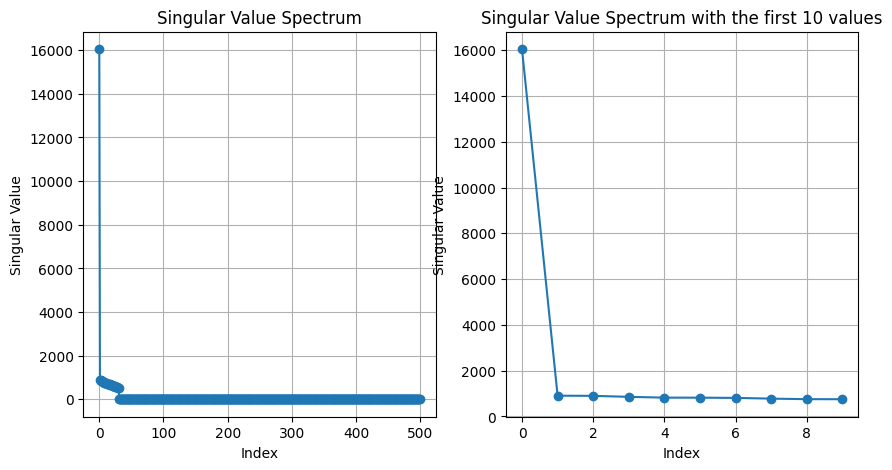

In [12]:
U, S, VT = np.linalg.svd(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(S, marker = 'o')
ax1.set(xlabel = 'Index', ylabel = 'Singular Value')
ax1.set_title("Singular Value Spectrum")
ax1.grid(True)

ax2.plot(S[0:10], marker = 'o')
ax2.set(xlabel = 'Index', ylabel = 'Singular Value')
ax2.set_title("Singular Value Spectrum with the first 10 values")
ax2.grid(True)

plt.show()

In [13]:
z_buggy, V_buggy, rec_X_buggy = buggy_PCA(X, d = 1)
rec_error_buggy = np.sum([calculate_euclidean_dist(X[i], rec_X_buggy[i])**2 for i in range(X.shape[0])])

z_demeaned, V_demeaned, rec_X_demeaned = demeaned_PCA(X, d = 1)
rec_error_demeaned = np.sum([calculate_euclidean_dist(X[i], rec_X_demeaned[i])**2 for i in range(X.shape[0])])

z_norm, V_norm, rec_X_norm = normalized_PCA(X, d = 1)
rec_error_norm = np.sum([calculate_euclidean_dist(X[i], rec_X_norm[i])**2 for i in range(X.shape[0])])

z_dro, V_dro, rec_X_dro = DRO(X, d = 1)
rec_error_dro = np.sum([calculate_euclidean_dist(X[i], rec_X_dro[i])**2 for i in range(X.shape[0])])

In [14]:
print(rec_error_buggy, rec_error_demeaned, rec_error_norm, rec_error_dro)

(14819446.00895384+0j) (14010680.606413543+0j) (14019805.662634388+0j) (15655777.685727308+0j)
